In [1]:
%matplotlib inline

# install pillow
!pip install Pillow -U

# download and unzip dataset o train
!wget http://images.cocodataset.org/zips/val2014.zip
!mkdir train
%cd /content/train
!unzip -qq /content/val2014.zip
%cd ..

#download model
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

     |████████████████████████████████| 4.3 MB 14.3 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


--2022-05-05 16:02:37--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.46.108
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.46.108|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  32.9MB/s    in 3m 19s  

2022-05-05 16:05:56 (31.8 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]

/content/train
/content
--2022-05-05 16:06:36--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘vgg16-00b39a1b.pth’

vgg16-00b39a1b.pth  100%[===================>] 527.81M  29.5MB/s    in 18s     

2022-0

In [2]:
!pip install --ignore-installed Pillow==9.0.0

     |████████████████████████████████| 4.3 MB 15.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time
import vgg16_fe as vgg # this is used to extract features
import vgg16 as vgg_model # this is used to train the model
import utils

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Trained on COCO dataset for VGG16 Model for different styles


## Rain Princess

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/rain_princess.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "rain_princess/models/"
SAVE_IMAGE_PATH = "rain_princess/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
def train():
    # seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # get the device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # load the training dataset
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # load the models and start training :)
    model = vgg_model.VGG16('/content/vgg16-00b39a1b.pth').to(device) #Creating a pretrained model object by loading the downloaded .pth file. This model object will be retrained 
    vgg16_fe = vgg.VGG16('/content/vgg16-00b39a1b.pth').to(device) #Creating a pretrained model object by loading the downloaded .pth file. This model object will be used to extract features and will not be retrained

    # get style features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    # load the style image
    style_image = utils.load_image(STYLE_IMAGE_PATH)
    # convert style image to tensor
    style_tensor = utils.itot(style_image).to(device)
    # add imagenet mean
    style_tensor = style_tensor.add(imagenet_neg_mean)

    B, C, H, W = style_tensor.shape
    # get the features of the style image
    style_features = vgg16_fe(style_tensor.expand([BATCH_SIZE, C, H, W]))

    # get the gram matrix of the style image
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = utils.gram(value)

    # Optimizer settings
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()

    # training loop
    for epoch in range(NUM_EPOCHS):
        print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
        for content_batch, _ in train_loader:
            # Get current batch size in case of odd batch sizes
            curr_batch_size = content_batch.shape[0]

            # free up unnecessary memory of cuda
            torch.cuda.empty_cache()

            # zero the gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = model(content_batch)

            # print("Content Batch: ", content_batch.shape)
            # print("Generated Batch: ", generated_batch.shape)

            content_features = vgg16_fe(content_batch.add(imagenet_neg_mean))
            generated_features = vgg16_fe(generated_batch.add(imagenet_neg_mean))

            # print("Generated Features:", generated_features['relu2_2'].shape)
            # print("Content Features:", content_features['relu2_2'].shape)

            # Calculate content loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(generated_features['relu2_2'], content_features['relu2_2'])            
            batch_content_loss_sum += content_loss

            # Calculate style loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(utils.gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss.item()

            # Calculate total loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backpropagation
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
                torch.save(model.state_dict(), checkpoint_path)
                
                print("Saved self trained VGG16 checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0) # clone to save inplace errors
                sample_image = utils.ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
                utils.saveimg(sample_image, sample_image_path)
                utils.show(sample_image)
                print("Saved sample stylized image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_total_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)
            
            # increment batch count
            batch_count += 1
    
    stop_time = time.time()
    # Print loss histories
    print("Done Training the Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history) 
    print("========Style Loss========")
    print(style_loss_history) 
    print("========Total Loss========")
    print(total_loss_history) 

    # Save TransformerNetwork weights
    model.eval()
    model.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving VGG16 weights at {}".format(final_path))
    torch.save(model.state_dict(), final_path)
    print("Done saving final model")

    # Plot Loss Histories
    if (PLOT_LOSS):
        utils.plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)


### Training

========Epoch 1/1========
========Iteration 1/10126========
	Content Loss:	3884623.75
	Style Loss:	73683472.00
	Total Loss:	77568096.00
Time elapsed:	0.8852720260620117 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_0.pth


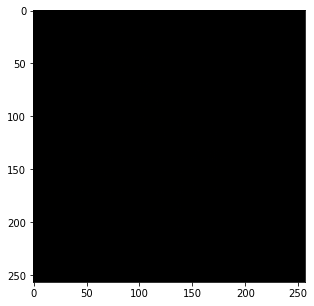

Saved sample stylized image at rain_princess/images/sample0_0.png
========Iteration 501/10126========
	Content Loss:	5897477.00
	Style Loss:	9779786.46
	Total Loss:	15677263.06
Time elapsed:	123.19219207763672 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_500.pth


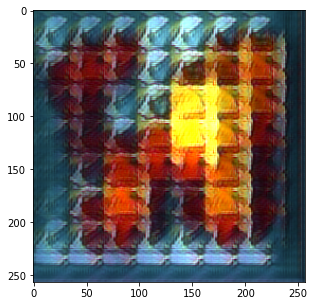

Saved sample stylized image at rain_princess/images/sample0_500.png
========Iteration 1001/10126========
	Content Loss:	5984127.50
	Style Loss:	5237265.50
	Total Loss:	11221390.14
Time elapsed:	253.33850121498108 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_1000.pth


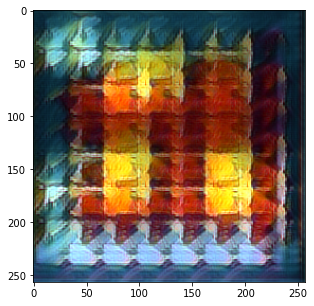

Saved sample stylized image at rain_princess/images/sample0_1000.png
========Iteration 1501/10126========
	Content Loss:	5978556.50
	Style Loss:	3675401.27
	Total Loss:	9653958.00
Time elapsed:	385.8635597229004 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_1500.pth


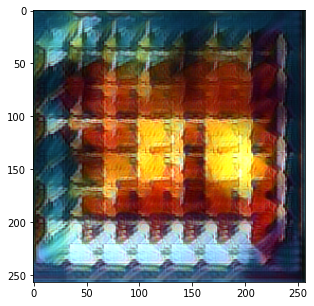

Saved sample stylized image at rain_princess/images/sample0_1500.png
========Iteration 2001/10126========
	Content Loss:	5954319.50
	Style Loss:	2886235.23
	Total Loss:	8840554.77
Time elapsed:	518.9107320308685 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_2000.pth


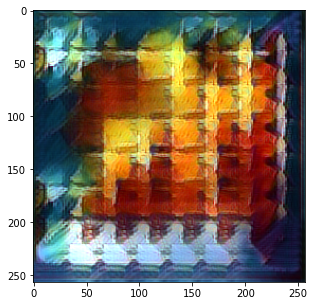

Saved sample stylized image at rain_princess/images/sample0_2000.png
========Iteration 2501/10126========
	Content Loss:	5924250.50
	Style Loss:	2410583.52
	Total Loss:	8334832.50
Time elapsed:	651.946230173111 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_2500.pth


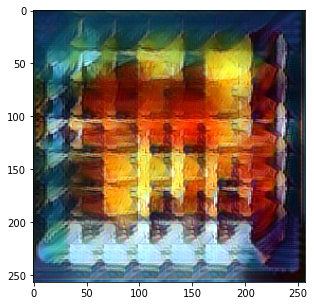

Saved sample stylized image at rain_princess/images/sample0_2500.png
========Iteration 3001/10126========
	Content Loss:	5899249.50
	Style Loss:	2092289.97
	Total Loss:	7991537.10
Time elapsed:	785.0240008831024 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_3000.pth


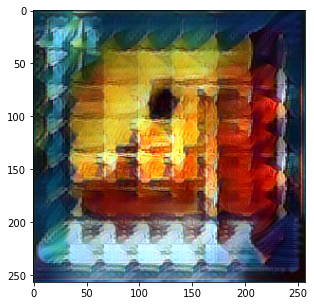

Saved sample stylized image at rain_princess/images/sample0_3000.png
========Iteration 3501/10126========
	Content Loss:	5860799.00
	Style Loss:	1865270.93
	Total Loss:	7726070.81
Time elapsed:	918.0352656841278 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_3500.pth


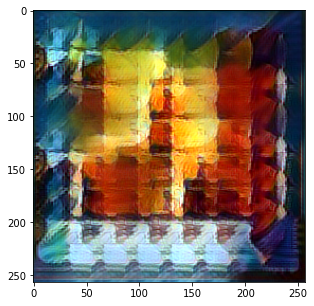

Saved sample stylized image at rain_princess/images/sample0_3500.png
========Iteration 4001/10126========
	Content Loss:	5829899.00
	Style Loss:	1695734.50
	Total Loss:	7525631.09
Time elapsed:	1051.2622492313385 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_4000.pth


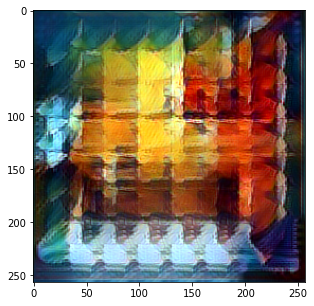

Saved sample stylized image at rain_princess/images/sample0_4000.png
========Iteration 4501/10126========
	Content Loss:	5802285.00
	Style Loss:	1563897.86
	Total Loss:	7366179.53
Time elapsed:	1184.1625244617462 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_4500.pth


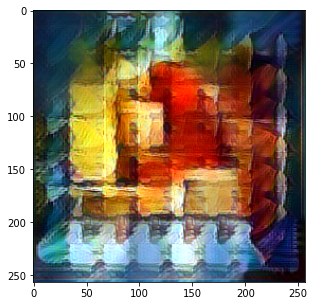

Saved sample stylized image at rain_princess/images/sample0_4500.png
========Iteration 5001/10126========
	Content Loss:	5772908.00
	Style Loss:	1458721.26
	Total Loss:	7231624.71
Time elapsed:	1316.7021305561066 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_5000.pth


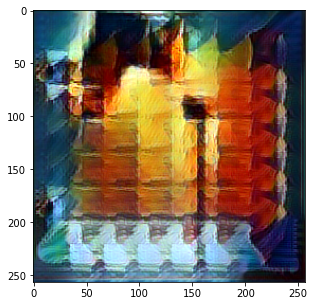

Saved sample stylized image at rain_princess/images/sample0_5000.png
========Iteration 5501/10126========
	Content Loss:	5747744.50
	Style Loss:	1372851.00
	Total Loss:	7120597.08
Time elapsed:	1449.5478029251099 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_5500.pth


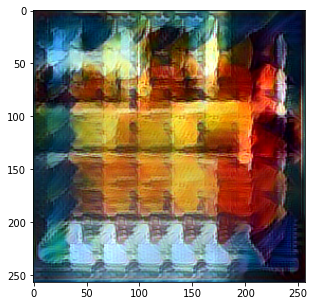

Saved sample stylized image at rain_princess/images/sample0_5500.png
========Iteration 6001/10126========
	Content Loss:	5721941.00
	Style Loss:	1301810.55
	Total Loss:	7023751.28
Time elapsed:	1582.4280803203583 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_6000.pth


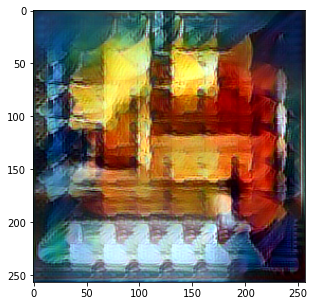

Saved sample stylized image at rain_princess/images/sample0_6000.png
========Iteration 6501/10126========
	Content Loss:	5699955.50
	Style Loss:	1242215.75
	Total Loss:	6942172.37
Time elapsed:	1715.1973686218262 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_6500.pth


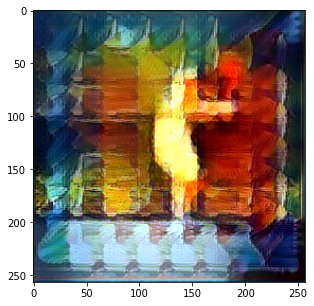

Saved sample stylized image at rain_princess/images/sample0_6500.png
========Iteration 7001/10126========
	Content Loss:	5678745.00
	Style Loss:	1191023.47
	Total Loss:	6869764.92
Time elapsed:	1848.0246648788452 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_7000.pth


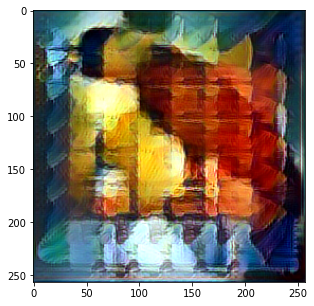

Saved sample stylized image at rain_princess/images/sample0_7000.png
========Iteration 7501/10126========
	Content Loss:	5654924.00
	Style Loss:	1146834.89
	Total Loss:	6801752.38
Time elapsed:	1980.9206912517548 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_7500.pth


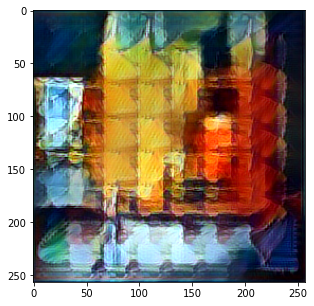

Saved sample stylized image at rain_princess/images/sample0_7500.png
========Iteration 8001/10126========
	Content Loss:	5631777.00
	Style Loss:	1108395.31
	Total Loss:	6740165.63
Time elapsed:	2113.5728030204773 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_8000.pth


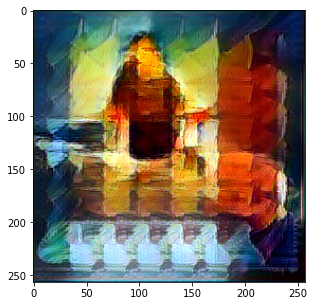

Saved sample stylized image at rain_princess/images/sample0_8000.png
========Iteration 8501/10126========
	Content Loss:	5611847.00
	Style Loss:	1074571.12
	Total Loss:	6686413.62
Time elapsed:	2246.8712270259857 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_8500.pth


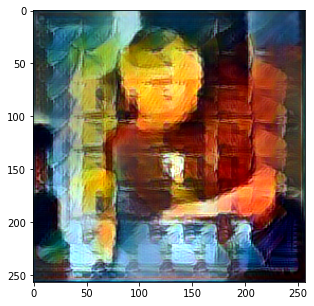

Saved sample stylized image at rain_princess/images/sample0_8500.png
========Iteration 9001/10126========
	Content Loss:	5592777.50
	Style Loss:	1044649.13
	Total Loss:	6637421.41
Time elapsed:	2379.6136314868927 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_9000.pth


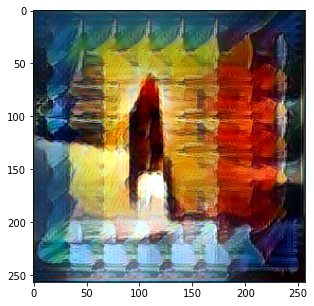

Saved sample stylized image at rain_princess/images/sample0_9000.png
========Iteration 9501/10126========
	Content Loss:	5574925.00
	Style Loss:	1017934.52
	Total Loss:	6592856.95
Time elapsed:	2512.0947518348694 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_9500.pth


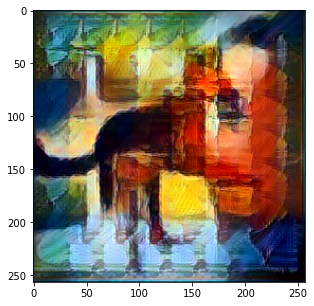

Saved sample stylized image at rain_princess/images/sample0_9500.png
========Iteration 10001/10126========
	Content Loss:	5556722.00
	Style Loss:	993920.19
	Total Loss:	6550638.02
Time elapsed:	2644.745475769043 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_10000.pth


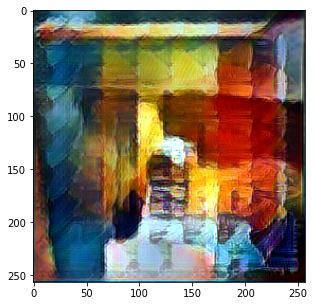

Saved sample stylized image at rain_princess/images/sample0_10000.png
========Iteration 10126/10126========
	Content Loss:	5552240.00
	Style Loss:	988344.78
	Total Loss:	6540580.60
Time elapsed:	2678.364708662033 seconds
Saved self trained VGG16 checkpoint file at rain_princess/models/checkpoint_10125.pth


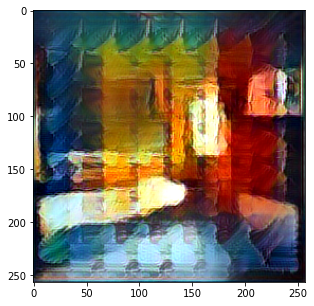

Saved sample stylized image at rain_princess/images/sample0_10125.png
Done Training the Network!
Training Time: 2678.7308571338654 seconds
========Content Loss========
[77568096.0, 15677263.061876247, 11221390.135864137, 9653958.004663557, 8840554.774612693, 8334832.50419832, 7991537.104965012, 7726070.805912596, 7525631.085353661, 7366179.52610531, 7231624.713257348, 7120597.081803309, 7023751.279370105, 6942172.368789417, 6869764.916940437, 6801752.375416611, 6740165.633483315, 6686413.6172215035, 6637421.408287968, 6592856.951794548, 6550638.02179782, 6540580.6021627495]
========Style Loss========
[73683472.0, 9779786.458083833, 5237265.499937562, 3675401.2695702864, 2886235.229572714, 2410583.5192797882, 2092289.974081556, 1865270.9287435734, 1695734.4956417147, 1563897.8596561875, 1458721.2644971006, 1372851.0025904381, 1301810.5452164223, 1242215.7513940162, 1191023.465134445, 1146834.8857485668, 1108395.3060515872, 1074571.1151482179, 1044649.1345544939, 1017934.5154227187, 9939

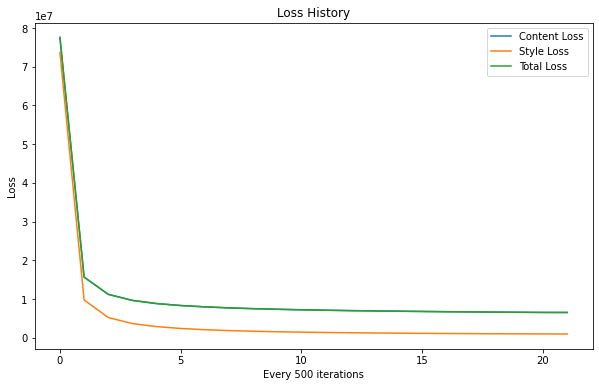

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r rain_princess/models/ /content/gdrive/My\ Drive/vgg_coco/rain_princess/
# copy the images folder to the folder in the google drive
!cp -r rain_princess/images/ /content/gdrive/My\ Drive/vgg_coco/rain_princess/

## The Scream

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/the_scream.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "the_scream/models/"
SAVE_IMAGE_PATH = "the_scream/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

========Epoch 1/1========
========Iteration 1/10126========
	Content Loss:	3884623.75
	Style Loss:	25371306.00
	Total Loss:	29255930.00
Time elapsed:	0.5187695026397705 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_0.pth


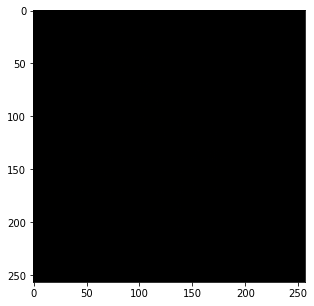

Saved sample stylized image at the_scream/images/sample0_0.png
========Iteration 501/10126========
	Content Loss:	3532394.50
	Style Loss:	2105895.59
	Total Loss:	5638291.00
Time elapsed:	128.9492528438568 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_500.pth


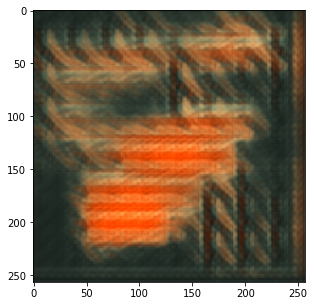

Saved sample stylized image at the_scream/images/sample0_500.png
========Iteration 1001/10126========
	Content Loss:	3499953.50
	Style Loss:	1182807.48
	Total Loss:	4682761.41
Time elapsed:	258.5777781009674 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_1000.pth


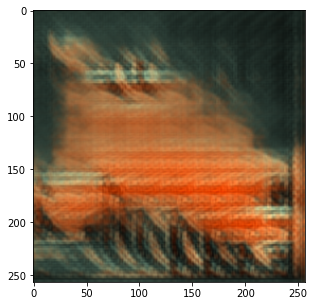

Saved sample stylized image at the_scream/images/sample0_1000.png
========Iteration 1501/10126========
	Content Loss:	3450781.75
	Style Loss:	875270.35
	Total Loss:	4326053.15
Time elapsed:	388.2501666545868 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_1500.pth


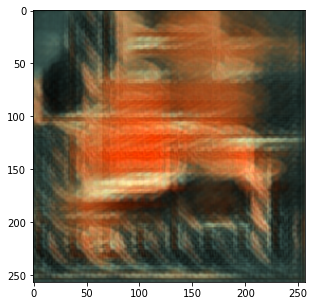

Saved sample stylized image at the_scream/images/sample0_1500.png
========Iteration 2001/10126========
	Content Loss:	3402033.25
	Style Loss:	719149.31
	Total Loss:	4121183.46
Time elapsed:	518.1819479465485 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_2000.pth


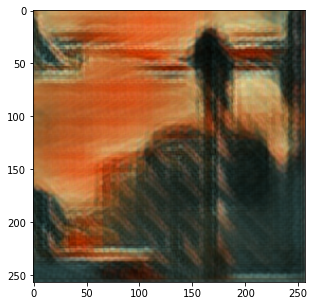

Saved sample stylized image at the_scream/images/sample0_2000.png
========Iteration 2501/10126========
	Content Loss:	3357561.75
	Style Loss:	624231.43
	Total Loss:	3981794.25
Time elapsed:	648.1278462409973 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_2500.pth


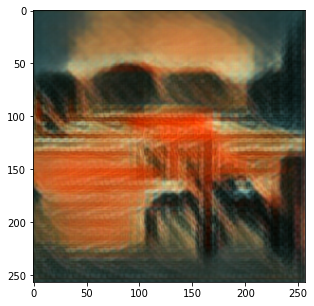

Saved sample stylized image at the_scream/images/sample0_2500.png
========Iteration 3001/10126========
	Content Loss:	3327336.75
	Style Loss:	560486.44
	Total Loss:	3887822.51
Time elapsed:	777.9626619815826 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_3000.pth


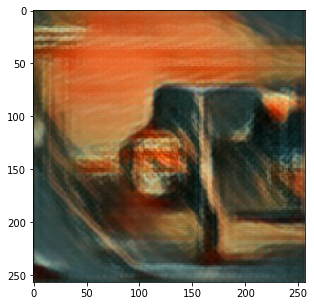

Saved sample stylized image at the_scream/images/sample0_3000.png
========Iteration 3501/10126========
	Content Loss:	3284903.75
	Style Loss:	514258.08
	Total Loss:	3799163.01
Time elapsed:	907.6430659294128 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_3500.pth


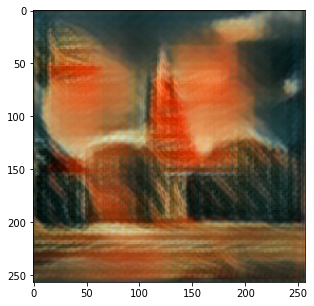

Saved sample stylized image at the_scream/images/sample0_3500.png
========Iteration 4001/10126========
	Content Loss:	3255903.25
	Style Loss:	479385.52
	Total Loss:	3735287.11
Time elapsed:	1037.423769235611 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_4000.pth


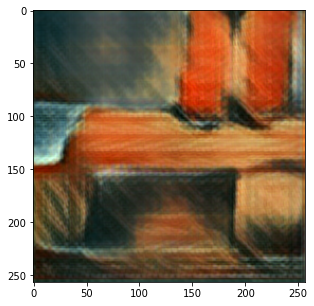

Saved sample stylized image at the_scream/images/sample0_4000.png
========Iteration 4501/10126========
	Content Loss:	3231710.00
	Style Loss:	452076.55
	Total Loss:	3683786.56
Time elapsed:	1167.4135901927948 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_4500.pth


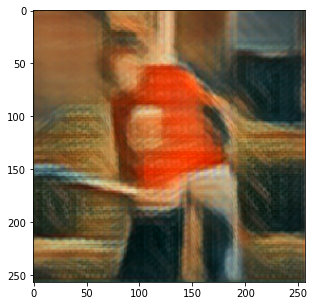

Saved sample stylized image at the_scream/images/sample0_4500.png
========Iteration 5001/10126========
	Content Loss:	3205861.25
	Style Loss:	430299.78
	Total Loss:	3636160.01
Time elapsed:	1297.3356719017029 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_5000.pth


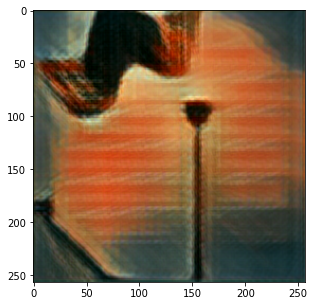

Saved sample stylized image at the_scream/images/sample0_5000.png
========Iteration 5501/10126========
	Content Loss:	3187302.25
	Style Loss:	412266.90
	Total Loss:	3599568.35
Time elapsed:	1427.1937096118927 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_5500.pth


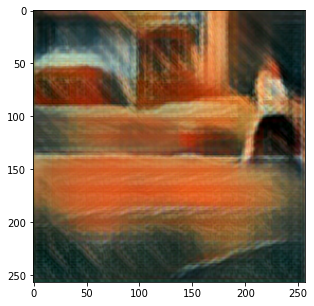

Saved sample stylized image at the_scream/images/sample0_5500.png
========Iteration 6001/10126========
	Content Loss:	3167909.00
	Style Loss:	397114.61
	Total Loss:	3565024.58
Time elapsed:	1557.2653815746307 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_6000.pth


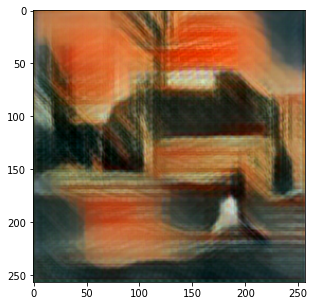

Saved sample stylized image at the_scream/images/sample0_6000.png
========Iteration 6501/10126========
	Content Loss:	3154006.00
	Style Loss:	384240.00
	Total Loss:	3538246.38
Time elapsed:	1687.3272006511688 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_6500.pth


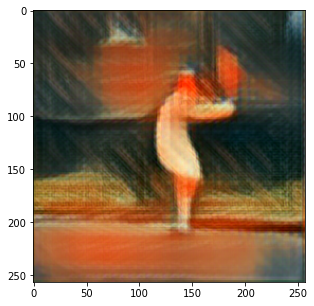

Saved sample stylized image at the_scream/images/sample0_6500.png
========Iteration 7001/10126========
	Content Loss:	3141865.00
	Style Loss:	373214.60
	Total Loss:	3515078.48
Time elapsed:	1817.2221944332123 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_7000.pth


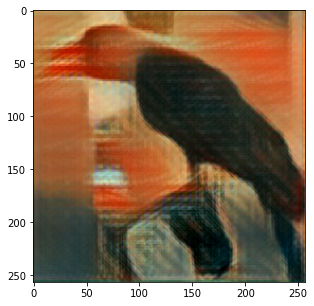

Saved sample stylized image at the_scream/images/sample0_7000.png
========Iteration 7501/10126========
	Content Loss:	3126382.00
	Style Loss:	363578.51
	Total Loss:	3489959.23
Time elapsed:	1947.0047376155853 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_7500.pth


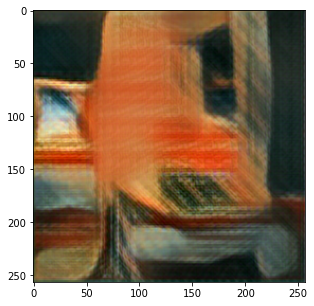

Saved sample stylized image at the_scream/images/sample0_7500.png
========Iteration 8001/10126========
	Content Loss:	3111423.50
	Style Loss:	355133.65
	Total Loss:	3466556.95
Time elapsed:	2076.972446203232 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_8000.pth


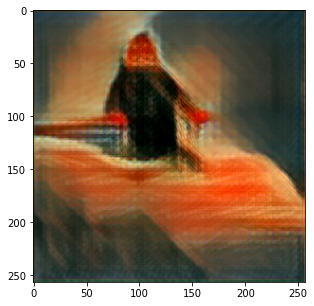

Saved sample stylized image at the_scream/images/sample0_8000.png
========Iteration 8501/10126========
	Content Loss:	3100297.25
	Style Loss:	347501.84
	Total Loss:	3447797.42
Time elapsed:	2206.8250644207 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_8500.pth


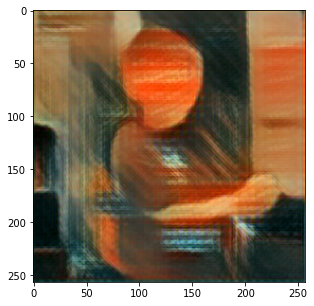

Saved sample stylized image at the_scream/images/sample0_8500.png
========Iteration 9001/10126========
	Content Loss:	3089864.50
	Style Loss:	340759.64
	Total Loss:	3430620.78
Time elapsed:	2336.781797885895 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_9000.pth


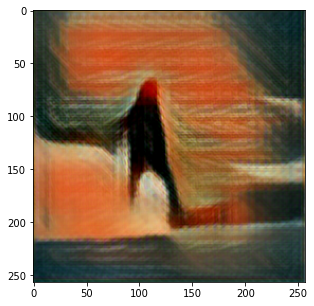

Saved sample stylized image at the_scream/images/sample0_9000.png
========Iteration 9501/10126========
	Content Loss:	3081134.50
	Style Loss:	334650.65
	Total Loss:	3415781.85
Time elapsed:	2466.8046197891235 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_9500.pth


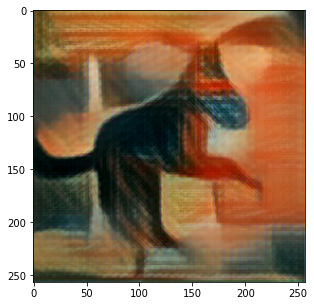

Saved sample stylized image at the_scream/images/sample0_9500.png
========Iteration 10001/10126========
	Content Loss:	3071361.00
	Style Loss:	329169.19
	Total Loss:	3400524.29
Time elapsed:	2597.358237504959 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_10000.pth


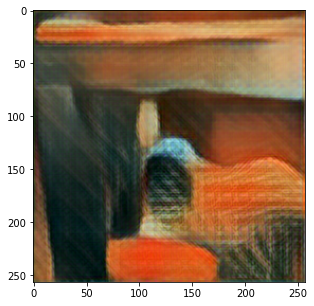

Saved sample stylized image at the_scream/images/sample0_10000.png
========Iteration 10126/10126========
	Content Loss:	3068961.00
	Style Loss:	327886.43
	Total Loss:	3396840.43
Time elapsed:	2630.416067838669 seconds
Saved self trained VGG16 checkpoint file at the_scream/models/checkpoint_10125.pth


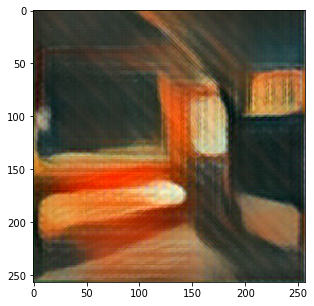

Saved sample stylized image at the_scream/images/sample0_10125.png
Done Training the Network!
Training Time: 2630.779773712158 seconds
========Content Loss========
[29255930.0, 5638291.001996008, 4682761.414585414, 4326053.146402398, 4121183.460769615, 3981794.24920032, 3887822.505914695, 3799163.007176521, 3735287.108847788, 3683786.5581537434, 3636160.0122975404, 3599568.348709326, 3565024.5836318946, 3538246.3750769114, 3515078.4847878874, 3489959.2284862017, 3466556.9467254095, 3447797.423964828, 3430620.7830796577, 3415781.850542048, 3400524.2941580843, 3396840.432068438]
========Style Loss========
[25371306.0, 2105895.5860466566, 1182807.4829233268, 875270.3543679214, 719149.3057377561, 624231.4311088065, 560486.4413216428, 514258.08068230504, 479385.52133060485, 452076.5538942735, 430299.78330896323, 412266.902228004, 397114.60712537495, 384240.0030956776, 373214.60113287385, 363578.50620333955, 355133.6485536964, 347501.8363593254, 340759.64117355016, 334650.6471736528, 329169.

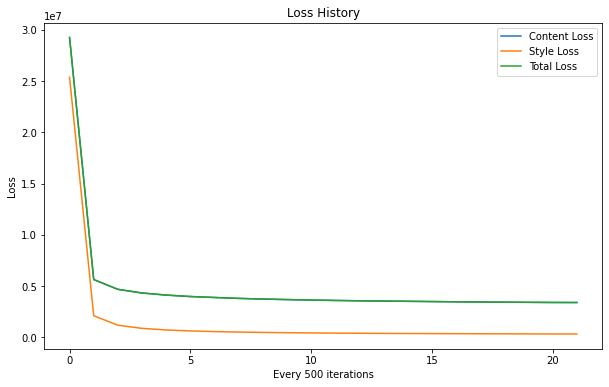

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r the_scream/models/ /content/gdrive/My\ Drive/vgg_coco/the_scream/
# copy the images folder to the folder in the google drive
!cp -r the_scream/images/ /content/gdrive/My\ Drive/vgg_coco/the_scream/

## The Shipwreck

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/the_shipwreck.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "the_shipwreck/models/"
SAVE_IMAGE_PATH = "the_shipwreck/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

========Epoch 1/1========
========Iteration 1/10126========
	Content Loss:	3884623.75
	Style Loss:	20166748.00
	Total Loss:	24051372.00
Time elapsed:	0.6985676288604736 seconds


FileNotFoundError: ignored

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r the_shipwreck/models/ /content/gdrive/My\ Drive/vgg_coco/the_shipwreck/
# copy the images folder to the folder in the google drive
!cp -r the_shipwreck/images/ /content/gdrive/My\ Drive/vgg_coco/the_shipwreck/

## Udnie

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/udnie.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "udnie/models/"
SAVE_IMAGE_PATH = "udnie/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r udnie/models/ /content/gdrive/My\ Drive/vgg_coco/udnie/
# copy the images folder to the folder in the google drive
!cp -r udnie/images/ /content/gdrive/My\ Drive/vgg_coco/udnie/

## Wave

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/wave.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "wave/models/"
SAVE_IMAGE_PATH = "wave/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r wave/models/ /content/gdrive/My\ Drive/vgg_coco/wave/
# copy the images folder to the folder in the google drive
!cp -r wave/images/ /content/gdrive/My\ Drive/vgg_coco/wave/